# OpenAI Embedding

## 事先准备
1.确保在环境中设置了 OpenAI API key
2.安装依赖包

In [42]:
!pip3 install tiktoken openai pandas matplotlib plotly scikit-learn numpy

## 数据集

本样例采用亚马逊美食评论数据集(amazon-fine-food-reviews) [美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)。该数据集包含截至2012年10月用户在亚马逊上留下的共计568454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本，模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

![dataset](figures/amazon-fine-food-reviews.png)

In [46]:
# Pandas 是一个用于数据处理和分析的 Python 库，它提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken

### 加载数据集

In [47]:
input_datapath = "data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = ("Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip())
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [48]:
df["combined"]

0      Title: where does one  start...and stop... wit...
1      Title: Arrived in pieces; Content: Not pleased...
2      Title: It isn't blanc mange, but isn't bad . ....
3      Title: These also have SALT and it's not sea s...
4      Title: Happy with the product; Content: My dog...
                             ...                        
995    Title: Delicious!; Content: I have ordered the...
996    Title: Good Training Treat; Content: My dog wi...
997    Title: Jamica Me Crazy Coffee; Content: Wolfga...
998    Title: Party Peanuts; Content: Great product f...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

## Embedding 
### 明确模型关键参数

In [49]:
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536，这里过滤 Token 超过 8000 的文本
max_tokens = 8000  

### 将样本减少到最近的1000个评论，并删除过长的样本

In [50]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values("Time").tail(top_n * 2) 
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
df.drop("Time", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

1000

### 生成 Embeddings 并保存


In [51]:
from openai import OpenAI

In [52]:
# OpenAI Python SDK v1.0 
client = OpenAI()

In [53]:
# 新版本创建 Embedding 向量的方法
res = client.embeddings.create(input="abc", model=embedding_model)
print(res.data[0].embedding)

[0.002615210600197315, -0.011296011507511139, -0.00963275134563446, -0.039097219705581665, -0.03448256105184555, 0.012145334854722023, -0.021303880959749222, -0.02280435338616371, 0.018685130402445793, -0.00038153232890181243, 0.0033760634250938892, 0.019194725900888443, -0.0026983735151588917, -0.004526189994066954, -0.018840840086340904, 0.0029708649963140488, 0.027093440294265747, 0.010666095651686192, 0.010800572112202644, 0.007530673872679472, -0.014537598006427288, 0.01776503026485443, -0.0069786133244633675, -0.01562756486237049, -0.020199758931994438, -0.003558314172551036, 0.009993714280426502, -0.020058205351233482, 0.026272427290678024, -0.007325420621782541, 0.00774300517514348, 0.013787361793220043, -0.007459897082298994, -0.009944169782102108, -0.010397142730653286, -0.014219101518392563, -0.013645808212459087, -0.015924828127026558, 0.010382987558841705, -0.00026408673147670925, 0.024347292259335518, 0.0045155733823776245, 0.014098781161010265, -0.022960063070058823, -0.

In [56]:
# 定义调用 embedding API 的函数
def embedding_text(text, model="text-embedding-ada-002"):
    res = client.embeddings.create(input=text, model=model)
    return res.data[0].embedding

真正生成 Embedding 的调用

In [57]:
# 实际生成会耗时几分钟，逐行调用 OpenAI Embedding API
df["embedding"] = df.combined.apply(embedding_text)
output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"
df.to_csv(output_datapath)

In [60]:
e0 = df["embedding"][0]
e0

[0.007000929210335016,
 -0.027453815564513206,
 0.010571849532425404,
 -0.014572381041944027,
 0.0044095199555158615,
 0.019988907501101494,
 0.0007045608945190907,
 -0.022064784541726112,
 -0.01924654096364975,
 -0.013534442521631718,
 0.018078001216053963,
 0.0040280260145664215,
 -0.03302156552672386,
 0.0001496117765782401,
 0.01585090160369873,
 0.01945275440812111,
 0.017816798761487007,
 -0.026312770321965218,
 -0.01938401535153389,
 -0.025130484253168106,
 -0.04753895476460457,
 -0.007244947832077742,
 0.023783225566148758,
 -0.008633448742330074,
 -0.009018379263579845,
 0.011396701447665691,
 0.02958468347787857,
 -0.022490957751870155,
 -0.010166297666728497,
 0.02167985402047634,
 0.0011479186359792948,
 0.009080243296921253,
 -0.01330073457211256,
 -0.01733563467860222,
 -0.005763651803135872,
 -0.010929285548627377,
 -0.026477741077542305,
 0.007396170869469643,
 0.022587191313505173,
 -0.02029135264456272,
 0.018985338509082794,
 -0.015424727462232113,
 0.009320824407041

## 操作 Embedding
### 读取 Embedding 文件

In [61]:
embedding_datapath = "data/fine_food_reviews_with_embeddings_1k.csv"
df_embedded = pd.read_csv(embedding_datapath, index_col=0)

#### 转化为 Embedding 向量

In [62]:
df_embedded["embedding"]

12     [-0.0005399271612986922, -0.004124758299440145...
13     [0.0068963742814958096, 0.0167608093470335, -0...
14     [-0.0023715533316135406, -0.021357767283916473...
15     [0.00226533692330122, 0.010306870564818382, 0....
16     [-0.027459919452667236, -0.009041198529303074,...
                             ...                        
447    [0.00796585250645876, 0.0017102764686569571, 0...
436    [0.001777207711711526, -0.011673098430037498, ...
437    [-0.005498920567333698, -0.014834611676633358,...
438    [-0.00294404081068933, -0.007058987859636545, ...
439    [-0.006043732166290283, -0.000693734094966203,...
Name: embedding, Length: 1000, dtype: object

In [63]:
len(df_embedded["embedding"][0])

34410

In [64]:
type(df_embedded["embedding"][0])

str

In [65]:
df_embedded["embedding"][0]

'[0.007060592994093895, -0.02732112631201744, 0.010580576956272125, -0.014588683843612671, 0.004358730278909206, 0.019923659041523933, 0.0006634345045313239, -0.02212364971637726, -0.01926366239786148, -0.013578063808381557, 0.018067417666316032, 0.004080294165760279, -0.032944850623607635, 0.00016059498011600226, 0.015798678621649742, 0.019414912909269333, 0.017888668924570084, -0.026317380368709564, -0.019387412816286087, -0.025107385590672493, -0.047382283955812454, -0.00719809252768755, 0.023828642442822456, -0.008463086560368538, -0.008923709392547607, 0.011433073319494724, 0.02945236675441265, -0.02250864915549755, -0.010174954310059547, 0.02161490172147751, 0.001189369591884315, 0.00905433390289545, -0.013364939950406551, -0.017421171069145203, -0.005912473425269127, -0.01095182541757822, -0.02648238092660904, 0.007328717038035393, 0.022481149062514305, -0.02023990824818611, 0.01907116360962391, -0.015303680673241615, 0.009205583482980728, -0.00831183698028326, 0.001719601568765

In [66]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [67]:
len(df_embedded["embedding_vec"][0])

1536

In [69]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145..."
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0..."


## 可视化 Embedding 向量

In [70]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [71]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [72]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [73]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [74]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [75]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [76]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [77]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

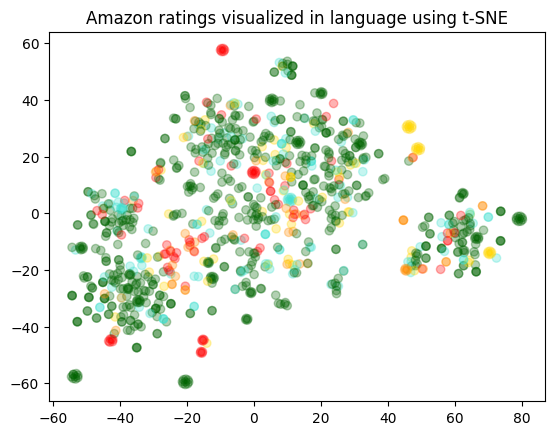

In [78]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，评论大致分为3个大类。**

## 使用 K-Means 聚类

In [79]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

In [80]:
df_embedded['Cluster']

12     0
13     0
14     1
15     3
16     0
      ..
447    1
436    1
437    2
438    1
439    0
Name: Cluster, Length: 1000, dtype: int32

In [81]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145...",0
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0...",0


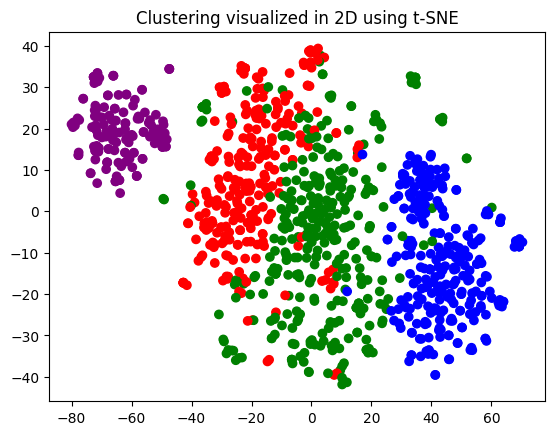

In [82]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类（官方介绍：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论）。**

## Embedding 文本搜索

![cosine](figures/cosine.png)

In [83]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [84]:
type(df_embedded["embedding_vec"][0])

list

In [85]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)
    
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [86]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning


In [87]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!


In [88]:
res = search_reviews(df_embedded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat


In [89]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!
